In [1]:
from collections import defaultdict
from itertools import islice, product
import random
import time
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import pandas as pd
from sympy import parse_expr, lambdify

import torch
import torch.nn as nn

In [2]:
def parameters(width, depth, dimension):
    """Computes number of parameters in MLP with widths `width`,
    depth `depth`, and input dimension `dimension`. Assumes the neurons
    have biases.
    """
    return (dimension * width + width) + (depth - 2)*(width * width + width) + (width + 1)

def width_given_ddp(depth, dimension, parameters):
    """Given the network depth and input dimension, computes the
    width such that the architecture (with bias) has `parameters` parameters.
    """
    if depth == 2:
        return int((parameters - 1) / (dimension + 2))
    root = (-(dimension + depth) + np.sqrt(np.power(dimension + depth, 2) - 4 * (depth - 2) * (1 - parameters))) / (2 * (depth - 2))
    return int(root)

In [3]:
def create_normalizer(mean, std):
    """Create a function to normalize data of the form (N, d) given the means
    and stds along each of the d columns.

    Args:
        mean: (mean[1], ..., mean[d])
        std: (std[1], ..., std[d])
    """
    assert len(mean) == len(std)
    def normalize(x):
        return torch.stack([(x[:, i] - mean[i]) / std[i] for i in range(len(mean))], dim=1)
    return normalize

In [4]:
eqn = 'Z.008'
width = 20
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [5]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [6]:
device

device(type='cuda', index=0)

In [7]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [8]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train_unnormalized = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train_unnormalized[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test_unnormalized = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test_unnormalized[:, i] for i in range(dimension)])

xs_train_unnormalized = torch.from_numpy(xs_train_unnormalized).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test_unnormalized = torch.from_numpy(xs_test_unnormalized).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [9]:
## Simplex interpolation first

from scipy import spatial, interpolate

tri = spatial.Delaunay(xs_train_unnormalized.detach().cpu().numpy())
f = interpolate.LinearNDInterpolator(tri, ys_train.detach().cpu().numpy())

# _log.debug("Evaluating model")
preds = f(xs_test_unnormalized.detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
simplex_rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.detach().cpu().numpy()[valid_idx], 2)))

In [10]:
assert xs_train_unnormalized.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test_unnormalized.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train_unnormalized)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train_unnormalized[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test_unnormalized) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))
unnormalized_min_test = min_test

  0%|          | 0/25000 [00:00<?, ?it/s]

In [11]:
unnormalized_min_test

0.5355542012134172

In [12]:
N = 400
# xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
#                       torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='xy')
xy = torch.meshgrid(torch.linspace(1, 5, N, device=device), 
                      torch.linspace(1, 5, N, device=device), indexing='xy')
xs_grid_unnormalized = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)

In [13]:
jacobians = []
for i in tqdm(range(N**2)):
    jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid_unnormalized[i]).detach().cpu().numpy())
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

  0%|          | 0/160000 [00:00<?, ?it/s]

In [14]:
jacobian_to_color = {jpy: matplotlib.cm.rainbow(np.random.rand())[:3] for jpy in set(jacobians_py)}

In [15]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades_unnormalized = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        shades_unnormalized[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'ReLU network')

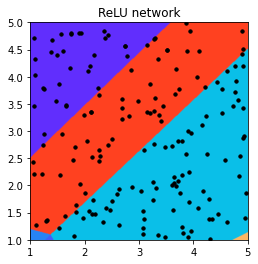

In [16]:
plt.imshow(shades_unnormalized, interpolation='bilinear', origin='lower', extent=[
    xs_grid_unnormalized[:, 0].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 0].max().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].max().cpu().numpy()
#     0, 6, 0, 6
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train_unnormalized.detach().cpu().numpy()), color='black', s=11)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU network")

In [17]:
eqn = 'Z.008'
width = 20
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [18]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [19]:
device

device(type='cuda', index=0)

In [20]:
equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

In [21]:
TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

In [22]:
normalize = create_normalizer(xs_train.mean(dim=0), xs_train.std(dim=0))

xs_train = normalize(xs_train)
xs_test = normalize(xs_test)

In [23]:
## Simplex interpolation first

# from scipy import spatial, interpolate

# tri = spatial.Delaunay(xs_train.detach().cpu().numpy())
# f = interpolate.LinearNDInterpolator(tri, ys_train.detach().cpu().numpy())

# # _log.debug("Evaluating model")
# preds = f(xs_test.detach().cpu().numpy())
# valid_idx = ~np.isnan(preds)
# rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.detach().cpu().numpy()[valid_idx], 2)))

In [24]:
assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
    #     _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))
# ex.info['min_train'] = min_train
# ex.info['min_test'] = min_test
# ex.info['test_at_min_train'] = test_at_min_train
# _log.debug("Test loss: {:.3e}".format(test_at_min_train))
normalized_min_test = min_test

  0%|          | 0/25000 [00:00<?, ?it/s]

In [25]:
normalized_min_test

0.05656662349755255

In [26]:
N = 400
# xy = torch.meshgrid(torch.linspace(ranges[0][0], ranges[0][1], N, device=device), 
#                       torch.linspace(ranges[1][0], ranges[1][1], N, device=device), indexing='xy')
xy = torch.meshgrid(torch.linspace(1, 5, N, device=device), 
                      torch.linspace(1, 5, N, device=device), indexing='xy')
xs_grid = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)
xs_grid = normalize(xs_grid)

In [27]:
jacobians = []
for i in tqdm(range(N**2)):
    jacobians.append(torch.autograd.functional.jacobian(mlp, inputs=xs_grid[i]).detach().cpu().numpy())
jacobians_py = [tuple(j.tolist()[0]) for j in jacobians]

  0%|          | 0/160000 [00:00<?, ?it/s]

In [28]:
jacobian_to_color = {jpy: matplotlib.cm.rainbow(np.random.rand())[:3] for jpy in set(jacobians_py)}

In [29]:
jacobians_grid = np.array(jacobians).reshape((N, N, 2))
shades = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        shades[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

Text(0.5, 1.0, 'ReLU network')

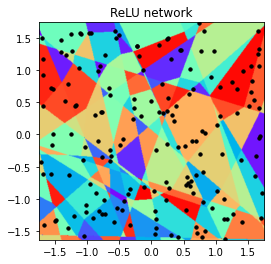

In [30]:
plt.imshow(shades, interpolation='bilinear', origin='lower', extent=[
    xs_grid[:, 0].min().cpu().numpy(), 
    xs_grid[:, 0].max().cpu().numpy(), 
    xs_grid[:, 1].min().cpu().numpy(), 
    xs_grid[:, 1].max().cpu().numpy()
#     0, 6, 0, 6
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=11)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title("ReLU network")

In [31]:
N = 400
xy = torch.meshgrid(torch.linspace(1, 5, N, device=device), 
                      torch.linspace(1, 5, N, device=device), indexing='xy')
xs_grid_unnormalized = torch.cat([xy[0].flatten().unsqueeze(dim=1), xy[1].flatten().unsqueeze(dim=1)], dim=1)
# xs_grid_unnormalized = normalize(xs_grid_unnormalized)

jacobians = []
for i in tqdm(range(N**2)):
    x = xs_grid_unnormalized[i].detach().cpu().numpy()
    dx = 1e-8
    dfdx = (f(x + np.array([dx, 0.0])) - f(x)) / dx
    dfdy = (f(x + np.array([0.0, dx])) - f(x)) / dx
    jac = np.array([dfdx, dfdy]).flatten()
    jac = np.round(jac, 3)
    jacobians.append(jac)


jacobians_py = [tuple(jac.tolist()) for jac in jacobians]

# min_angle = 
jacobian_to_color = dict()
for jpy in set(jacobians_py):
    if np.any(np.isnan(jpy)):
        jacobian_to_color['nan'] = np.array([1., 1., 1.]) # white background
    else:
#         jacobian_to_color[jpy] = matplotlib.cm.gnuplot2((np.arctan2(jpy[1], jpy[0]) + np.pi)/(2*np.pi))[:-1]
        jacobian_to_color[jpy] = matplotlib.cm.rainbow(np.random.rand())[:-1]
    
# jacobian_to_color = {jpy: (1.0 if np.any(np.isnan(jpy)) else np.arctan2(jpy[0], jpy[1])) for jpy in set(jacobians_py)}

jacobians_grid = np.array(jacobians).reshape((N, N, 2))
max_jacobian_norm = np.nanmax(np.linalg.norm(jacobians_grid, ord=2, axis=2))

shades_simplex = np.zeros((N, N, 3))
for i in range(N):
    for j in range(N):
        if np.any(np.isnan(jacobians_grid[i, j])):
            shades_simplex[i, j] = jacobian_to_color['nan']
        else:
#             shades_simplex[i, j] = color_scheme(jacobians_grid[i, j], mag_norm=max_jacobian_norm)
            shades_simplex[i, j] = jacobian_to_color[tuple(jacobians_grid[i, j].tolist())]

  0%|          | 0/160000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'simplex')

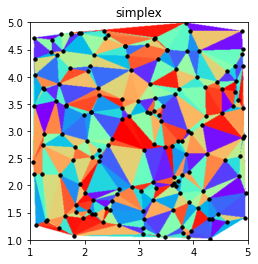

In [32]:
plt.imshow(shades_simplex, interpolation='bilinear', origin='lower', extent=[
    xs_grid_unnormalized[:, 0].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 0].max().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].max().cpu().numpy()
])
plt.title(r"$f(x, y) = xy$")
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train_unnormalized.detach().cpu().numpy()), color='black', s=11)
plt.title("simplex")

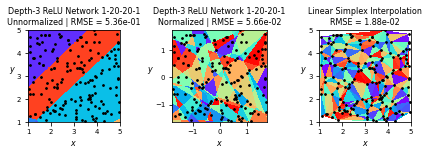

In [35]:
plt.figure(figsize=(6.0, 2.0))

plt.subplot(1, 3, 1)
plt.imshow(shades_unnormalized, interpolation='none', origin='lower', extent=[
    xs_grid_unnormalized[:, 0].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 0].max().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].max().cpu().numpy()
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train_unnormalized.detach().cpu().numpy()), color='black', s=3)
# plt.ylim(ranges[0][0], ranges[0][1])
# plt.ylim(ranges[1][0], ranges[1][1])
plt.title(f"Depth-3 ReLU Network 1-{(str(width)+'-')*(depth-1)}1\nUnnormalized | RMSE = {unnormalized_min_test:.2e}", fontsize=8)
# plt.title("ReLU MLP", fontsize=8)
plt.xlabel(r"$x$", fontsize=8)
plt.ylabel(r"$y$", rotation=0, fontsize=8)
plt.xticks([1, 2, 3, 4, 5], fontsize=7)
plt.yticks([1, 2, 3, 4, 5], fontsize=7)


plt.subplot(1, 3, 2)
plt.imshow(shades, interpolation='none', origin='lower', extent=[
    xs_grid[:, 0].min().cpu().numpy(), 
    xs_grid[:, 0].max().cpu().numpy(), 
    xs_grid[:, 1].min().cpu().numpy(), 
    xs_grid[:, 1].max().cpu().numpy()
])
# plt.title(r"$f(x, y) = xy$")
# plt.plot([1.0, 5.0], [1.0, 1.0], color='black')
# plt.plot([5.0, 5.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 1.0], [1.0, 5.0], color='black')
# plt.plot([1.0, 5.0], [5.0, 5.0], color='black')
plt.scatter(*zip(*xs_train.detach().cpu().numpy()), color='black', s=3)
# plt.ylabel(ranges[0][0], ranges[0][1])
# plt.ylabel(ranges[1][0], ranges[1][1])
plt.title("ReLU MLP (normalized data)", fontsize=6)
plt.title(f"Depth-3 ReLU Network 1-{(str(width)+'-')*(depth-1)}1\nNormalized | RMSE = {normalized_min_test:.2e}", fontsize=8)
plt.xlabel(r"$x$", fontsize=8)
plt.ylabel(r"$y$", rotation=0, fontsize=8)
plt.xticks([-1, 0, 1], fontsize=7)
plt.yticks([-1, 0, 1], fontsize=7)

plt.subplot(1, 3, 3)
plt.imshow(shades_simplex, interpolation='none', origin='lower', extent=[
    xs_grid_unnormalized[:, 0].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 0].max().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].min().cpu().numpy(), 
    xs_grid_unnormalized[:, 1].max().cpu().numpy()
])
# plt.xlim(-np.sqrt(12) / 2.0, np.sqrt(12) / 2.0)
# plt.ylim(-np.sqrt(12) / 2.0, np.sqrt(12) / 2.0)
# plt.title(r"$f(x, y) = xy$", fontsize=8)
# plt.ylabel(ranges[0][0], ranges[0][1])
# plt.ylabel(ranges[1][0], ranges[1][1])
plt.scatter(*zip(*xs_train_unnormalized.detach().cpu().numpy()), color='black', s=3)
plt.title(f"Linear Simplex Interpolation\nRMSE = {simplex_rmse_loss:.2e}", fontsize=8)
# reduce distance between title and top axis
plt.subplots_adjust(top=0.8)
plt.xlabel(r"$x$", fontsize=8)
plt.ylabel(r"$y$", rotation=0, fontsize=8)
plt.xticks([1, 2, 3, 4, 5], fontsize=7)
plt.yticks([1, 2, 3, 4, 5], fontsize=7)

plt.tight_layout(pad=0.15)

plt.savefig("../final-figures/2d-linear-regions.pdf")